## Install relevant dependencies
I make the assumption that Pytorch is already installed

In [12]:
!pip install python-chess
!pip install tqdm

## Download chess game data
Can skip this step if your own pgns to use

In [13]:
!curl https://database.lichess.org/standard/lichess_db_standard_rated_2013-01.pgn.zst --output games.pgn.zst
!zstd --decompress games.pgn.zst

# !mkdir pgns/ # uncomment if pgns dir does not exist
!mv games.pgn pgns/
!rm games.pgn.zst

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.9M  100 16.9M    0     0  2369k      0  0:00:07  0:00:07 --:--:-- 2642k
games.pgn.zst       : 92811021 bytes                                           


## Create list of games

In [47]:
import chess.pgn

pgn = open("pgns/games.pgn", "r", encoding="utf-8")

all_games= []

# while True: 
for i in range(5000): # increase this limit for a better model
    game = chess.pgn.read_game(pgn)
    if game is None:
        break  # End of games
        
    all_games.append(game)

pgn.close()
print(f"{len(all_games)} games parsed")

1000 games parsed


## Create list of distinct chess positions
Goal of this is to create diverse set of chess FENs that can be used to create the training dataset

In [48]:
import random

all_positions = set()

for game in all_games:
    board = game.board()
    moves = list(game.mainline_moves())
    positions = []
    
    for move in moves:
        board.push(move)
        positions.append(board.fen())
    
    random_positions = random.sample(positions, min(10, len(moves)) // 7)
    all_positions.update(random_positions)

all_positions = list(all_positions)
print(f"{len(all_positions)} unique positions")

957 unique positions


## Define functions to convert between tensor and FEN string
This will let us encode chess positions in a way the NNs can use

In [30]:
import torch

piece_to_idx = {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
                'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11}

def pos_to_tensor(fen, device="cpu"):
    parts = fen.split(" ")
    wtm = parts[1] == "w"
    castling_rights = parts[2]

    board = chess.Board(fen)
    tensor = torch.zeros(15, 8, 8, device=device)

    for row in range(8): 
        for col in range(8):
            sqr = chess.square(col, 7 - row)
            piece = board.piece_at(sqr)
            if piece != None:
                p = piece.symbol()
                idx = piece_to_idx[p]
                tensor[idx, row, col] = 1 if p.isupper() else -1
                  
    # Encode castling rights
    if 'K' in castling_rights:
        tensor[12, 0, 0] = 1
    if 'Q' in castling_rights:
        tensor[12, 0, 7] = 1
    if 'k' in castling_rights:
        tensor[13, 7, 0] = -1  
    if 'q' in castling_rights:
        tensor[13, 7, 7] = -1
          
    # Encode side to move
    tensor[14] = 1 if wtm else -1
      
    return tensor

def tensor_to_pos(tensor):
    board = chess.Board(None)
    piece_symbols = list(piece_to_idx.keys())
    
    # Decode the board pieces
    for idx, piece_symbol in enumerate(piece_symbols[:12]):
        mask = tensor[idx].abs() > 0
        positions = mask.nonzero(as_tuple=True)
        for row, col in zip(*positions):
            square = chess.square(col, 7 - row)
            board.set_piece_at(square, chess.Piece.from_symbol(piece_symbol))
    
    # Decode castling rights
    castling_rights = ''
    if tensor[12, 0, 0] == 1:
        castling_rights += 'K'
    if tensor[12, 0, 7] == 1:
        castling_rights += 'Q'
    if tensor[13, 7, 0] == -1:
        castling_rights += 'k'
    if tensor[13, 7, 7] == -1:
        castling_rights += 'q'
    board.set_castling_fen(castling_rights)
    
    # Decode side to move
    side_to_move = 'w' if tensor[14].mean() > 0 else 'b'
    board.turn = True if side_to_move == 'w' else False
    
    return board.fen()
    
print(f"Shape of encoded chess position tensor: {pos_to_tensor(all_positions[0]).shape}")

Shape of encoded chess position tensor: torch.Size([15, 8, 8])


## Set pytorch device to cuda if available

In [25]:
torch.cuda.memory._record_memory_history()
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device("cpu")
print(f"using {device}")

using cuda


## Create datasets for training and testing

In [49]:
from torch.utils.data import Dataset, DataLoader

class PositionDataset(Dataset):
  def __init__(self, tensors):
        self.tensors = tensors

  def __len__(self):
      return len(self.tensors)

  def __getitem__(self, idx):
        return self.tensors[idx]

tensors = [pos_to_tensor(pos, device) for pos in all_positions]
random.shuffle(tensors)

# Calculate the indices for splitting
total_tensors = len(tensors)
train_end = int(total_tensors * 0.8)
val_end = int(total_tensors * 0.9)

# Split the tensors into train, validation, and test sets
train_tensors = tensors[:train_end]
val_tensors = tensors[train_end:val_end]
test_tensors = tensors[val_end:]

# Create datasets for each split
train_dataset = PositionDataset(train_tensors)
val_dataset = PositionDataset(val_tensors)
test_dataset = PositionDataset(test_tensors)

print(f"len training set: {len(train_dataset)}")
print(f"len validation set: {len(val_dataset)}")
print(f"len test set: {len(test_dataset)}")

len training set: 765
len validation set: 96
len test set: 96


## Define the structure of the NN
We are training an autoencoder that will learn to deconstruct, then reconstruct chess positions.\
Once trained, we can use the encoder to generate our embeddings

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, hyperparams):
        super(Encoder, self).__init__()

        channels = hyperparams["position_channels"]
        n_embed = hyperparams["n_embed"]
        filters = hyperparams["filters"]
        fc_size = hyperparams["fc_size"]
        
        self.conv1 = nn.Conv2d(channels, filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(filters * 2, filters * 4, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(filters * 4 * 1 * 1, fc_size)
        self.fc2 = nn.Linear(fc_size, n_embed)  # Compressed representation

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))  
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, hyperparams):        
        super(Decoder, self).__init__()

        channels = hyperparams["position_channels"]
        n_embed = hyperparams["n_embed"]
        filters = hyperparams["filters"]
        fc_size = hyperparams["fc_size"]

        
        self.fc1 = nn.Linear(n_embed, fc_size)
        self.fc2 = nn.Linear(fc_size, filters * 4 * 1 * 1)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(filters * 4 , 1, 1))
        self.deconv1 = nn.ConvTranspose2d(filters * 4, filters * 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(filters * 2, filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(filters, channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.unflatten(x)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        return x

class PositionAutoEncoder(nn.Module):
    def __init__(self, hyperparams):
        super(PositionAutoEncoder, self).__init__()
        self.encoder = Encoder(hyperparams)
        self.decoder = Decoder(hyperparams)

    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

    @torch.no_grad()
    def embed(self, x):
        code = self.encoder(x)
        return code

## Define model hyperparameter

In [50]:
hyperparams = {
    "batch_size": 32,
    "n_epochs": 50,
    "learning_rate": 17e-4,
    "dropout_rate": 0,
    "position_channels": 15,
    "n_embed": 128,
    "filters": 32,
    "fc_size": 256,
    "version": 6
}

batch_size = hyperparams["batch_size"]
n_epochs = hyperparams["n_epochs"]
learning_rate = hyperparams["learning_rate"]

## Initialize the model and optimizer

In [51]:
from torch.optim import AdamW, lr_scheduler

# init dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#init model
model = PositionAutoEncoder(hyperparams)
model.to(device)

# init optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_params = sum(p.numel() for p in model.parameters())/1e6
print(f"{num_params:.2f}M parameters")

# init lr scheduler
num_training_steps = n_epochs * len(train_loader)
scheduler = lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=learning_rate, total_steps=num_training_steps)
print(f"training iterations: {num_training_steps}")


0.33M parameters
training iterations: 1200


## Run the training loop
We train by minimizing MSE loss on the reconstructed posittion encoding.\
Validation loss is calculated after each epoch to ensure learning

In [52]:
from tqdm.auto import tqdm

criterion = nn.MSELoss()
progress_bar = tqdm(range(num_training_steps))

for epoch in range(n_epochs):
    model.train() # switch model to training mode

    for batch in train_loader:
        batch = batch.to(device)
        outputs = model(batch)
        loss = criterion(outputs, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        progress_bar.update(1)
    
    print(f"finished epcoh: {epoch}")
    with torch.no_grad():
        # evaluate validation loss
        model.eval() # switch model to evaluation mode
        losses = torch.zeros(len(val_loader), device=device)
        k = 0
        for batch in val_loader:
            batch = batch.to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch)
                
            losses[k] = loss.item()
            k += 1

        avg_val_loss = losses.mean()
        # -----------------------------
        
        # evaluate training loss
        losses =  torch.zeros(len(train_loader), device=device)
        k = 0
        for batch in train_loader:
            batch = batch.to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch)
                
            losses[k] = loss.item()
            k += 1
            
            if(k == len(train_loader)):
                break
        
        avg_train_loss = losses.mean()
        # ------------------------------
        print(f"learning rate: {optimizer.param_groups[0]['lr']}")
        print(f"val loss: {avg_val_loss}")
        print(f"train loss: {avg_train_loss}")
    

  2%|▎         | 30/1200 [00:00<00:10, 116.19it/s]

finished epcoh: 0
learning rate: 8.593067038494299e-05
val loss: 0.0969051942229271
train loss: 0.0962725281715393
finished epcoh: 1


  6%|▌         | 69/1200 [00:00<00:07, 142.92it/s]

learning rate: 0.00013893466943081835
val loss: 0.09617742151021957
train loss: 0.09553806483745575
finished epcoh: 2
learning rate: 0.00022468259214748982
val loss: 0.09364902973175049
train loss: 0.09304150193929672


  8%|▊         | 98/1200 [00:00<00:11, 95.72it/s] 

finished epcoh: 3
learning rate: 0.0003394060127054814
val loss: 0.07725556194782257
train loss: 0.075750932097435


 11%|█▏        | 137/1200 [00:01<00:10, 106.17it/s]

finished epcoh: 4
learning rate: 0.00047806309816494333
val loss: 0.051555778831243515
train loss: 0.04978548735380173


 12%|█▏        | 149/1200 [00:01<00:11, 90.58it/s] 

finished epcoh: 5
learning rate: 0.0006345601855457031
val loss: 0.026963835582137108
train loss: 0.026240525767207146


 16%|█▌        | 186/1200 [00:01<00:09, 102.36it/s]

finished epcoh: 6
learning rate: 0.0008020195844310251
val loss: 0.020989209413528442
train loss: 0.020847465842962265


 16%|█▋        | 197/1200 [00:01<00:11, 89.22it/s] 

finished epcoh: 7
learning rate: 0.0009730818357908276
val loss: 0.019105220213532448
train loss: 0.0192458163946867


 19%|█▉        | 231/1200 [00:02<00:10, 92.43it/s]

finished epcoh: 8
learning rate: 0.00114022914343776
val loss: 0.01822523958981037
train loss: 0.01858503557741642


 21%|██▏       | 256/1200 [00:02<00:09, 100.18it/s]

finished epcoh: 9
learning rate: 0.0012961157640405774
val loss: 0.017826981842517853
train loss: 0.018305376172065735


 24%|██▎       | 282/1200 [00:02<00:08, 103.91it/s]

finished epcoh: 10
learning rate: 0.001433890835806506
val loss: 0.017604392021894455
train loss: 0.018173079937696457


 24%|██▍       | 293/1200 [00:02<00:09, 93.81it/s] 

finished epcoh: 11
learning rate: 0.0015474994582475635
val loss: 0.017417222261428833
train loss: 0.01795363985002041


 27%|██▋       | 320/1200 [00:03<00:09, 96.48it/s] 

finished epcoh: 12
learning rate: 0.0016319487912611077
val loss: 0.018060078844428062
train loss: 0.01853322796523571


 29%|██▉       | 346/1200 [00:03<00:09, 88.26it/s] 

finished epcoh: 13
learning rate: 0.001683527479076319
val loss: 0.01732501946389675
train loss: 0.01790422946214676


 31%|███       | 368/1200 [00:03<00:09, 86.71it/s]

finished epcoh: 14
learning rate: 0.0016999940553285107
val loss: 0.017161279916763306
train loss: 0.01779361441731453


 33%|███▎      | 394/1200 [00:04<00:08, 92.90it/s] 

finished epcoh: 15
learning rate: 0.0016962872819508952
val loss: 0.01722177490592003
train loss: 0.017901739105582237


 35%|███▍      | 419/1200 [00:04<00:08, 95.64it/s] 

finished epcoh: 16
learning rate: 0.0016857667283626757
val loss: 0.01728944480419159
train loss: 0.01788700744509697


 37%|███▋      | 448/1200 [00:04<00:07, 105.42it/s]

finished epcoh: 17
learning rate: 0.0016685170998753586
val loss: 0.0172696765512228
train loss: 0.017842719331383705


 40%|███▉      | 475/1200 [00:04<00:06, 108.38it/s]

finished epcoh: 18
learning rate: 0.001644677280354907
val loss: 0.017178907990455627
train loss: 0.017742570489645004


 41%|████      | 487/1200 [00:04<00:07, 99.49it/s] 

finished epcoh: 19
learning rate: 0.0016144392140105125
val loss: 0.017079371958971024
train loss: 0.01767139509320259


 43%|████▎     | 514/1200 [00:05<00:06, 99.73it/s] 

finished epcoh: 20
learning rate: 0.0015780463599726852
val loss: 0.01710139773786068
train loss: 0.01770029589533806


 45%|████▌     | 540/1200 [00:05<00:06, 95.64it/s] 

finished epcoh: 21
learning rate: 0.0015357917321034856
val loss: 0.017020277678966522
train loss: 0.01766926236450672


 47%|████▋     | 569/1200 [00:05<00:06, 105.06it/s]

finished epcoh: 22
learning rate: 0.0014880155398211982
val loss: 0.017201796174049377
train loss: 0.017687439918518066


 50%|████▉     | 597/1200 [00:05<00:05, 112.03it/s]

finished epcoh: 23
learning rate: 0.0014351024489341333
val loss: 0.017135240137577057
train loss: 0.01766011118888855


 51%|█████     | 609/1200 [00:06<00:05, 102.35it/s]

finished epcoh: 24
learning rate: 0.0013774784845377206
val loss: 0.016993455588817596
train loss: 0.017599044367671013


 53%|█████▎    | 635/1200 [00:06<00:05, 95.83it/s] 

finished epcoh: 25
learning rate: 0.0013156076009109372
val loss: 0.016986658796668053
train loss: 0.01760384626686573


 55%|█████▌    | 664/1200 [00:06<00:05, 101.97it/s]

finished epcoh: 26
learning rate: 0.0012499879460292557
val loss: 0.01712806336581707
train loss: 0.01763782650232315


 57%|█████▊    | 690/1200 [00:06<00:04, 106.24it/s]

finished epcoh: 27
learning rate: 0.001181147850770051
val loss: 0.01700860634446144
train loss: 0.017583779990673065


 58%|█████▊    | 702/1200 [00:07<00:05, 98.97it/s] 

finished epcoh: 28
learning rate: 0.0011096415751030296
val loss: 0.01697729527950287
train loss: 0.017604997381567955


 61%|██████    | 730/1200 [00:07<00:04, 103.14it/s]

finished epcoh: 29
learning rate: 0.0010360448455148535
val loss: 0.016951315104961395
train loss: 0.01756332814693451


 63%|██████▎   | 757/1200 [00:07<00:04, 98.95it/s] 

finished epcoh: 30
learning rate: 0.0009609502195979905
val loss: 0.016939565539360046
train loss: 0.01757555827498436


 65%|██████▌   | 784/1200 [00:07<00:03, 105.07it/s]

finished epcoh: 31
learning rate: 0.0008849623151253977
val loss: 0.016935907304286957
train loss: 0.01755615882575512


 68%|██████▊   | 810/1200 [00:08<00:03, 106.54it/s]

finished epcoh: 32
learning rate: 0.0008086929420237244
val loss: 0.01686008647084236
train loss: 0.017535969614982605


 68%|██████▊   | 822/1200 [00:08<00:03, 98.66it/s] 

finished epcoh: 33
learning rate: 0.0007327561764395201
val loss: 0.016890008002519608
train loss: 0.017524506896734238


 71%|███████   | 849/1200 [00:08<00:03, 95.38it/s] 

finished epcoh: 34
learning rate: 0.0006577634165591739
val loss: 0.01689448580145836
train loss: 0.017530158162117004


 73%|███████▎  | 875/1200 [00:08<00:03, 97.74it/s] 

finished epcoh: 35
learning rate: 0.0005843184599902134
val loss: 0.016856275498867035
train loss: 0.01752113550901413


 75%|███████▌  | 904/1200 [00:09<00:02, 105.14it/s]

finished epcoh: 36
learning rate: 0.0005130126423379967
val loss: 0.016874117776751518
train loss: 0.01750311627984047


 78%|███████▊  | 931/1200 [00:09<00:02, 108.64it/s]

finished epcoh: 37
learning rate: 0.0004444200761191177
val loss: 0.01686071790754795
train loss: 0.017517292872071266


 79%|███████▊  | 943/1200 [00:09<00:02, 99.88it/s] 

finished epcoh: 38
learning rate: 0.0003790930283449952
val loss: 0.01686585694551468
train loss: 0.017509235069155693


 81%|████████  | 969/1200 [00:09<00:02, 97.52it/s] 

finished epcoh: 39
learning rate: 0.0003175574739926243
val loss: 0.016874950379133224
train loss: 0.017492635175585747


 83%|████████▎ | 995/1200 [00:09<00:02, 99.16it/s] 

finished epcoh: 40
learning rate: 0.00026030886116333005
val loss: 0.016852404922246933
train loss: 0.0174824558198452


 85%|████████▌ | 1023/1200 [00:10<00:01, 104.22it/s]

finished epcoh: 41
learning rate: 0.00020780812202597504
val loss: 0.016856104135513306
train loss: 0.017480358481407166


 88%|████████▊ | 1050/1200 [00:10<00:01, 110.24it/s]

finished epcoh: 42
learning rate: 0.0001604779616621584
val loss: 0.0168237816542387
train loss: 0.017478618770837784


 88%|████████▊ | 1062/1200 [00:10<00:01, 98.48it/s] 

finished epcoh: 43
learning rate: 0.00011869945469344583
val loss: 0.016836244612932205
train loss: 0.01748008280992508


 91%|█████████ | 1088/1200 [00:10<00:01, 98.26it/s] 

finished epcoh: 44
learning rate: 8.280897709258544e-05
val loss: 0.016843846067786217
train loss: 0.01747475005686283


 93%|█████████▎| 1115/1200 [00:11<00:00, 98.78it/s] 

finished epcoh: 45
learning rate: 5.309549788195982e-05
val loss: 0.016839098185300827
train loss: 0.017470311373472214


 95%|█████████▌| 1144/1200 [00:11<00:00, 105.88it/s]

finished epcoh: 46
learning rate: 2.97982525249304e-05
val loss: 0.016833918169140816
train loss: 0.017470110207796097


 98%|█████████▊| 1171/1200 [00:11<00:00, 109.25it/s]

finished epcoh: 47
learning rate: 1.3104816742553363e-05
val loss: 0.016832126304507256
train loss: 0.017469722777605057


 99%|█████████▊| 1183/1200 [00:11<00:00, 99.47it/s] 

finished epcoh: 48
learning rate: 3.149596264167319e-06
val loss: 0.01683385670185089
train loss: 0.017470989376306534


100%|█████████▉| 1197/1200 [00:11<00:00, 109.09it/s]

finished epcoh: 49
learning rate: 1.2744671489308643e-08
val loss: 0.016833819448947906
train loss: 0.017472824081778526


## Save the trained model weights and metadata

In [53]:
# !mkdir models  # uncomment to create models/ dir
checkpoint = {
    "model": model.state_dict(),
    "train_set": train_dataset,
    "val_set": val_dataset,
    "test_set": test_dataset,
    "hyperparameters": hyperparams
}
torch.save(checkpoint, f"models/v0.pt")

## Load a saved model

In [59]:
chkp = torch.load("models/v0.pt")
emb_model = PositionAutoEncoder(chkp["hyperparameters"]).to(device)
emb_model.eval()
emb_model.load_state_dict(chkp["model"])

train_dataset = chkp["train_set"]
val_dataset = chkp["val_set"]
test_dataset = chkp["test_set"]
embed_data = list(train_dataset + val_dataset + test_dataset)

## Embed collection of chess positions

In [84]:
batches = [embed_data[i:i + 256] for i in range(0, len(embed_data), 256)]
embeds = torch.cat([emb_model.embed(torch.stack(batch)) for batch in batches]).unsqueeze(1)
embeds.shape

torch.Size([957, 1, 128])

## Seacrh similar positions

In [98]:
# embed a query position
query = emb_model.embed(test_dataset[0].unsqueeze(0)).unsqueeze(0)

# calculate similarities and find top matches
similarities = F.cosine_similarity(embeds, query, dim=2)
top_matches = torch.topk(similarities, 10, dim=0)

# print(top_matches.values)

# convert matches to FEN strings
top_tensors = torch.stack(list(embed_data))[top_matches.indices].squeeze(1)
top_tensors = list(torch.split(top_tensors, 1, dim=0))
positions = [tensor_to_pos(t.squeeze(0)) for t in top_tensors]
query_pos = tensor_to_pos(test_dataset[0])

print(f"query position: {query_pos}")
print(f"similar positions: {positions}")

query position: r5nr/3nk2p/pp1p1p2/7B/3PP3/8/P1P2PPP/1N2K2R w K - 0 1
similar positions: ['r5nr/3nk2p/pp1p1p2/7B/3PP3/8/P1P2PPP/1N2K2R w K - 0 1', '2rq1rk1/pb1nbp1p/1p2p1p1/3pP3/3P4/1P1B1N1P/PB3PP1/R2Q1RK1 w - - 0 1', '2rq1rk1/pb1n1ppn/1p2p3/3p2B1/2PP4/P4N2/1PQ2PPP/1K1R3R w - - 0 1', 'r1bq2k1/6p1/p1n3Np/3pp1rQ/2p1p3/8/PPP2PPP/R4RK1 w - - 0 1', 'r5k1/pp2ppbp/4b1p1/2p5/1P2n3/PnP1PN2/RB2BPPP/1N1r2K1 w - - 0 1', 'r2qnrk1/pp1b3p/4p1pQ/3pPpb1/P1pP4/2P1P3/1PBN2PP/R1B2RK1 w - - 0 1', '2r1kb1r/3np1p1/pp3p1p/8/1npP2b1/1N3NB1/PPP1BPPP/3R1RK1 w k - 0 1', '3r3r/pR2nkpp/4b3/2p1P3/4PB2/2N2N2/PPP3PP/4K2R w K - 0 1', 'r2q1Bk1/1b1p1p1p/p5p1/3p2N1/2p1P2P/2b5/P4PP1/3Q1RK1 w - - 0 1', 'r2q1rk1/pp1b1pp1/1np2b1p/4N3/8/2QB2B1/PP3PPP/1K1R3R w - - 0 1']


## Inspect similar positions
Pass a FEN string to chess.Board() to view it

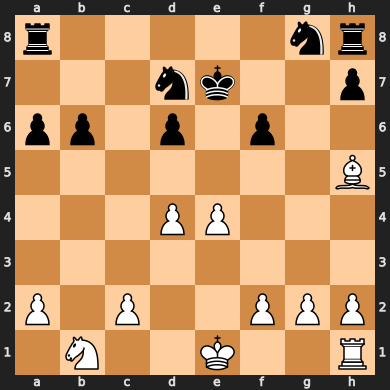

In [93]:
chess.Board(query_pos)

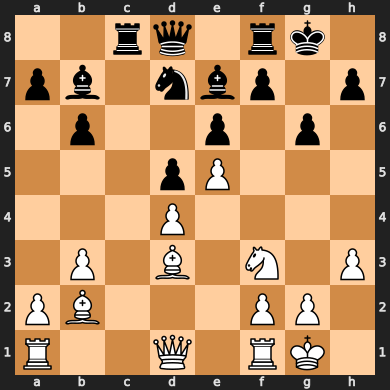

In [95]:
 chess.Board(positions[1])